In [28]:
%%capture
!pip install tensorflow nltk

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from nltk.util import ngrams
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/datasets/NER darija.csv')

In [32]:
data.isna().sum()

Sentence    0
Token       7
Tag         0
dtype: int64

In [33]:
data = data.dropna()
data.isna().sum()

Sentence    0
Token       0
Tag         0
dtype: int64

In [34]:
# Generate N-grams
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n))

In [35]:
# Preparing the dataset
sentences_dict = defaultdict(lambda: {"tokens": [], "tags": []})
for _, row in data.iterrows():
    sentences_dict[row['Sentence']]['tokens'].append(row['Token'])
    sentences_dict[row['Sentence']]['tags'].append(row['Tag'])


In [36]:
print(sentences_dict)

defaultdict(<function <lambda> at 0x7a1eba36b010>, {0: {'tokens': ['Uppsala', ')', 'هيّا', 'رابع', 'أكبر', 'مدينة', 'ف', 'سّويد', 'من', 'بعد', 'سطوكهولم', '،', 'ݣوتنبورݣ', 'ؤ', 'مالمو', '.'], 'tags': ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-LOC', 'O']}, 1: {'tokens': ['ف', '2018', 'كان', 'عدد', 'سّكان', 'ديالها', '172', '،', '402', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, 2: {'tokens': ['أوپيك', '(', 'ب', 'لينݣليزية', ':', 'OPEC', '-', 'تاتعني', 'لمنضمة', 'د', 'لبلدان', 'اللي', 'كاتصدّر', 'لپطرول', ')', '،', 'هي', 'منضمة', 'عالمية', 'تاتجمع', 'بلدان', 'اللي', 'تيعوّل', 'لإقتصاد', 'ديالها', 'بزاف', 'على', 'لپطرول', '.'], 'tags': ['B-ORG', 'O', 'O', 'B-MISC', 'O', 'B-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, 3: {'tokens': ['تأسسات', 'هاد', 'لمنضمة', 'نهار', '14', 'شتنبر', '1960', 'ف', 'بغداد', 'و', 'كانو', 'فيه

In [37]:
n = 16  # Ngrams
ngrams_dict = defaultdict(lambda: {"ngrams": [], "tags": []})
for sent_id, sent_data in sentences_dict.items():
    ngrams = get_ngrams(sent_data['tokens'], n)
    ngram_tags = get_ngrams(sent_data['tags'], n)
    ngrams_dict[sent_id]['ngrams'] = [" ".join(ngram) for ngram in ngrams]
    ngrams_dict[sent_id]['tags'] = ngram_tags


In [38]:
# Flatten the data
all_ngrams = [ngram for sent in ngrams_dict.values() for ngram in sent['ngrams']]
all_tags = [tag for sent in ngrams_dict.values() for tag in sent['tags']]


In [39]:
# Tokenization and Padding
tokenizer = Tokenizer(lower=False,oov_token='<OOV>')
tokenizer.fit_on_texts(all_ngrams)
X = tokenizer.texts_to_sequences(all_ngrams)
X = pad_sequences(X, padding='post')
print(X)

[[12452   102  1880 ... 12454     0     0]
 [ 3213    14   822 ...     0     0     0]
 [   14   822  9041 ...     0     0     0]
 ...
 [ 5262     2   372 ...     7   618     0]
 [ 5262     2   372 ...     7   618     7]
 [    2   372  5894 ...   618     7  1347]]


In [40]:
np.array(X).shape

(32286, 16)

In [41]:
# Tag encoding
unique_tags = set(tag for tag_pair in all_tags for tag in tag_pair)
tag2index = {tag: i for i, tag in enumerate(unique_tags)}
y = [[tag2index.get(tag) for tag in tag_pair] for tag_pair in all_tags]

y = pad_sequences(y, padding='post', maxlen=X.shape[1])
y = to_categorical(y, num_classes=len(tag2index))

In [42]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# Reshape y for categorical cross-entropy
y = np.array(y)
y = np.expand_dims(y, -1)

In [44]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]
num_class = y.shape[2]

In [45]:
max_length

16

In [46]:
# Model definition
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    tf.keras.layers.Masking(mask_value=0.0),
    tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_class, activation='softmax'),
])

In [47]:
# Model compilation
LR = 1e-4
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                   loss='categorical_crossentropy',  # changed to categorical_crossentropy
                   metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 50)            645300    
                                                                 
 masking_1 (Masking)         (None, 16, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 64)            29440     
                                                                 
 dropout_2 (Dropout)         (None, 16, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 16, 512)           33280     
                                                                 
 dropout_3 (Dropout)         (None, 16, 512)           0         
                                                                 
 dense_3 (Dense)             (None, 16, 9)            

In [48]:
# Callbacks
checkpoint_lstm = tf.keras.callbacks.ModelCheckpoint(
    'LSTM_NER_Model.h5',
    save_best_only=True,
    save_weights_only=True
)
early_stop = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-4,
    patience=5
)

In [49]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [50]:
# Model training
EPOCHS = 100
BATCH_SIZE = 32
history_lstm = model_lstm.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                              validation_split=0.2, callbacks=[early_stop, checkpoint_lstm])


Epoch 1/100
646/646 [==============================] - 76s 82ms/step - loss: 0.9278 - accuracy: 0.8574 - val_loss: 0.5510 - val_accuracy: 0.8635
Epoch 2/100
646/646 [==============================] - 15s 23ms/step - loss: 0.4900 - accuracy: 0.8659 - val_loss: 0.4416 - val_accuracy: 0.8666
Epoch 3/100
646/646 [==============================] - 8s 13ms/step - loss: 0.4214 - accuracy: 0.8698 - val_loss: 0.4055 - val_accuracy: 0.8721
Epoch 4/100
646/646 [==============================] - 9s 15ms/step - loss: 0.3949 - accuracy: 0.8749 - val_loss: 0.3856 - val_accuracy: 0.8764
Epoch 5/100
646/646 [==============================] - 11s 17ms/step - loss: 0.3751 - accuracy: 0.8785 - val_loss: 0.3662 - val_accuracy: 0.8813
Epoch 6/100
646/646 [==============================] - 8s 12ms/step - loss: 0.3545 - accuracy: 0.8836 - val_loss: 0.3449 - val_accuracy: 0.8881
Epoch 7/100
646/646 [==============================] - 10s 15ms/step - loss: 0.3316 - accuracy: 0.8905 - val_loss: 0.3207 - val_accur

202/202 [==============================] - 2s 4ms/step


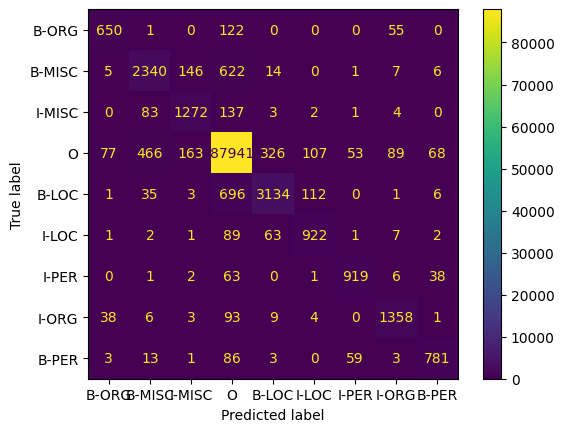

In [51]:
# Model evaluation
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=-1)
CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test.flatten(), y_pred_lstm.flatten()),
                            display_labels=list(tag2index.keys()))
CM.plot()
plt.show()

In [52]:
print(classification_report(y_test.flatten(), y_pred_lstm.flatten()))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       828
           1       0.79      0.74      0.77      3141
           2       0.80      0.85      0.82      1502
           3       0.98      0.98      0.98     89290
           4       0.88      0.79      0.83      3988
           5       0.80      0.85      0.82      1088
           6       0.89      0.89      0.89      1030
           7       0.89      0.90      0.89      1512
           8       0.87      0.82      0.84       949

    accuracy                           0.96    103328
   macro avg       0.86      0.85      0.85    103328
weighted avg       0.96      0.96      0.96    103328



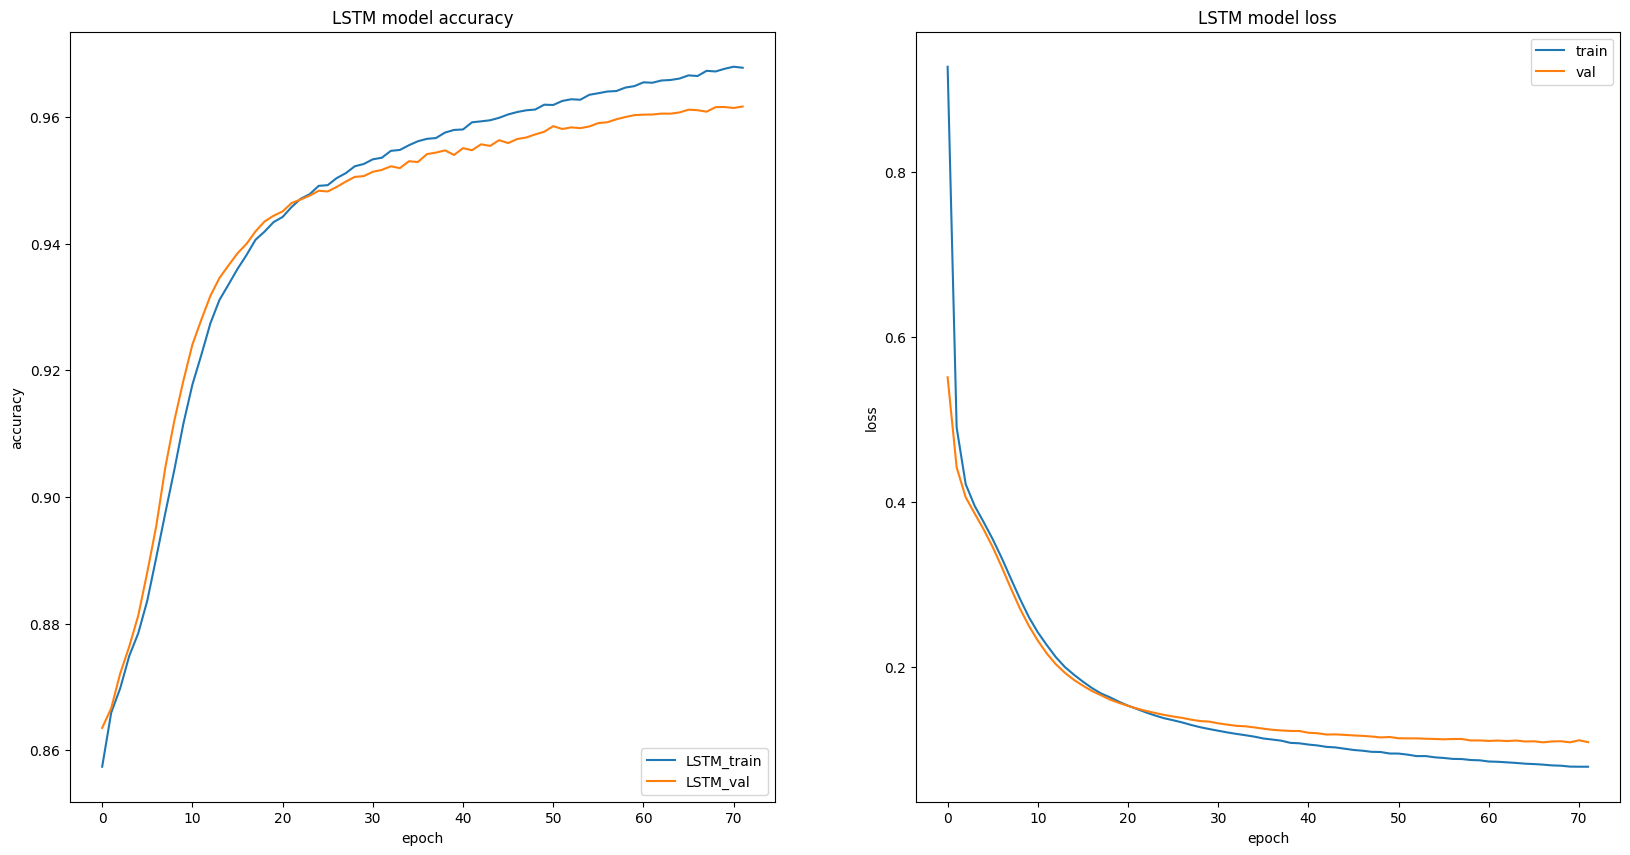

In [53]:
s, (at, al) = plt.subplots(1,2)
s.set_figwidth(20)
s.set_figheight(10)
at.plot(history_lstm.history['accuracy'])
at.plot(history_lstm.history['val_accuracy'])
at.set_title('LSTM model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='lower right')

al.plot(history_lstm.history['loss'])
al.plot(history_lstm.history['val_loss'])
al.set_title('LSTM model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper right')